| [**Lattice QCD I**](https://homepages.uni-regensburg.de/~lec17310/teaching/wise2122/lqft.html) | - | [**Christoph Lehner**](https://go.ur.de/lehner) |
|:-|--|-:|

# Chapter 2: Markov Chain Monte Carlo (MCMC) methods

As seen in the last chapter, we can learn about the spectrum and matrix elements in the Hilbert space of our Hamiltonian from correlation functions of operators.  In this chapter we discuss how we can compute such correlation functions by interpreting the Euclidean path integral in a probabilistic manner.

## Probabilistic interpretation of correlation functions

The Euclidean correlators discussed in the last chapter can be written as
$$
\begin{align}
\langle f(x_1,\ldots,x_N) \rangle &= \int dx_1 \cdots dx_N f(x_1,\ldots,x_N) p(x_1,\ldots,x_N)
\end{align}
$$
with probability density
$$
p(x_1,\ldots,x_N) = \frac{e^{-S_E(x_1,\ldots,x_N,x_1)}}{\int dx_1 \cdots dx_{N} e^{- S_E(x_1,x_2,\ldots,x_{N},x_1)}} \,. 
$$
This is possible since $e^{-S_E(x_1,\ldots,x_N,x_1)}$ is purely real and bound to a finite domain.
Therefore the above normalization process yields a $p(x_1,\ldots,x_N)$
with
$$
p(x_1,\ldots,x_N) \geq 0
$$
and
$$
\int dx_1 \cdots dx_{N} p(x_1,\ldots,x_N) = 1 \,.
$$

In this chapter, we explore how to generate variables $x_1,\ldots,x_N$ following a given probability distribution.  We first introduce a new statistical concept.

## Markov chain over a finite set of states

Let us consider a sequence of random variables
$$
\begin{align}
  x_0, x_1, \ldots
\end{align}
$$
with $x_i \in X$ with finite set $X=\{1,\ldots,n\}$ and $n \in \mathbb{N}$.

The probability of drawing a particular finite sequence from $x_0$ to $x_m$ shall then be given by
$$
\begin{align}
  P(x_m \cap x_{m-1} \cap \ldots \cap x_0) = P(x_m \vert x_{m-1} \cap \ldots \cap x_0) P(x_{m-1} \cap \ldots \cap x_0) \,.
\end{align}
$$
We call such a process a **Markov chain** if
$$
\begin{align}
  P(x_m \vert x_{m-1} \cap \ldots \cap x_0) = P(x_m \vert x_{m-1}) \,.
\end{align}
$$
If there is no explicit dependence on $m$, we call such a chain **time-homogenous**
and define the transition probability
$$
\begin{align}
  T_{ij} = P(x_m = j \vert x_{m-1} = i) \,.
\end{align}
$$
This matrix trivially must satisfy $T_{ij} \geq 0$ and $\sum_{j=1}^n T_{ij}=1$.

We now define a probability vector $p_m$ by its elements
$$
\begin{align}
  (p_m)_i = P(x_m = i)
\end{align}
$$
with $\sum_i (p_m)_i = 1$.  With this we find
$$
\begin{align}
  (p_m)_j = P(x_m = j) = P(x_m = j \vert x_{m-1} = i) P(x_{m-1} = i) =
  T_{ij} (p_{m-1})_i
\end{align}
$$
or in matrix form
$$
\begin{align}
  p_m^T = p_{m-1}^T T
\end{align}
$$
and therefore also
$$
\begin{align}
  p_m^T = p_{0}^T T^{m} \,.
\end{align}
$$

### Numerical example with three states

We first define a system with three possible states "A", "B", and "C".  We then consider a Markov chain with given transition probability.

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

T = {
    "A": { "A" : 0.5, "B" : 0.25, "C" : 0.25},
    "B": { "A" : 0.1, "B" : 0.5, "C" : 0.4},
    "C": { "A" : 0.2, "B" : 0.1, "C" : 0.7}
}

def update(state):
    return random.choices(
        population = [k for k in T[state]],
        weights = [T[state][k] for k in T[state]],
        k = 1
    )[0]

s = "A"
for i in range(10):
    sp = update(s)
    print(s,"->",sp)
    s = sp

A -> A
A -> B
B -> B
B -> B
B -> C
C -> C
C -> B
B -> C
C -> C
C -> A


Next, we check our implementation against the given transition probability.

In [2]:
for start in [ "A", "B", "C" ]:
    histogram = { "A" : 0, "B": 0 , "C": 0}
    N = 10000
    for i in range(N):
        histogram[update(start)] += 1.0 / N
    for target in [ "A", "B", "C" ]:
        print(f"T({start} -> {target}) = {histogram[target]} versus {T[start][target]}")

T(A -> A) = 0.5008999999999612 versus 0.5
T(A -> B) = 0.24949999999998884 versus 0.25
T(A -> C) = 0.24959999999998883 versus 0.25
T(B -> A) = 0.1023000000000019 versus 0.1
T(B -> B) = 0.4968999999999616 versus 0.5
T(B -> C) = 0.4007999999999722 versus 0.4
T(C -> A) = 0.20209999999999406 versus 0.2
T(C -> B) = 0.10420000000000196 versus 0.1
T(C -> C) = 0.6936999999999399 versus 0.7


Next, let us create a Markov chain of length $N$, starting from state "A" and look at the distribution of states.

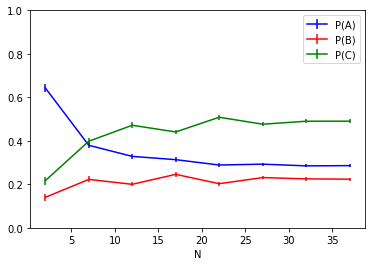

In [3]:
def distribution(N, start = "A", nsamples = 200):
    all_histograms = []
    for j in range(nsamples):
        chain = [start]
        for i in range(N):
            chain.append(update(chain[-1]))
    
        histogram = { "A" : 0, "B": 0 , "C": 0}
        for c in chain:
            histogram[c] += 1.0 / (N+1)
        
        all_histograms.append([ histogram[k] for k in T])

    return np.mean(all_histograms, axis=0), np.std(all_histograms, axis=0) / np.sqrt(nsamples)

Ns = list(range(2,40,5))
Ds = [distribution(N) for N in Ns]

fig, ax = plt.subplots()

ax.errorbar(Ns, [d[0][0] for d in Ds], [d[1][0] for d in Ds], c='blue', label="P(A)")
ax.errorbar(Ns, [d[0][1] for d in Ds], [d[1][1] for d in Ds], c='red', label="P(B)")
ax.errorbar(Ns, [d[0][2] for d in Ds], [d[1][2] for d in Ds], c='green', label="P(C)")

ax.legend()
plt.ylim(0,1)
plt.xlabel("N")
plt.show()

Next let us study a matrix version of the transition probability and its left eigensystem.

In [4]:


matT = np.matrix([ [ T[A][B] for B in T ] for A in T])
print("T=",matT)

mat_evals, mat_evecs = np.linalg.eig(matT.T)
print("Eigenvalues of T^T:",mat_evals)

unit_evec=mat_evecs[:,0]/np.sum(mat_evecs[:,0])
print("First left-eigenvector of T:",unit_evec,"corresponding to eigenvalue",mat_evals[0])

T= [[0.5  0.25 0.25]
 [0.1  0.5  0.4 ]
 [0.2  0.1  0.7 ]]
Eigenvalues of T^T: [1.  +0.j        0.35+0.1118034j 0.35-0.1118034j]
First left-eigenvector of T: [[0.25287356+0.j]
 [0.22988506+0.j]
 [0.51724138+0.j]] corresponding to eigenvalue (0.9999999999999987+0j)


So we have one eigenvalue **1** and other eigenvalues of smaller magnitude.  After a large number of applications of $T$, and therefore after many steps in a Markov chain, the probability distribution in this example will converge to a stationary probability distribution with probabilities.

In [5]:
print("P(A)=",unit_evec[0,0].real)
print("P(B)=",unit_evec[1,0].real)
print("P(C)=",unit_evec[2,0].real)

P(A)= 0.25287356321839094
P(B)= 0.22988505747126417
P(C)= 0.5172413793103449


Let us add this to the plot and make plots for starting state "A", "B", and "C".

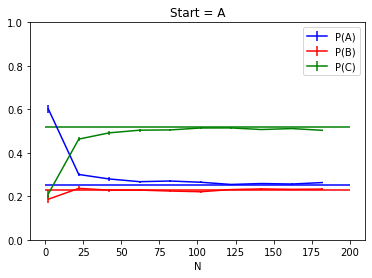

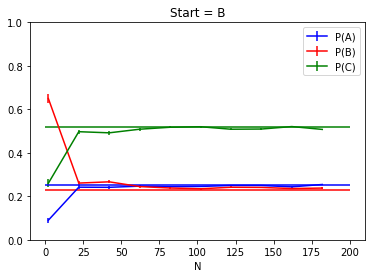

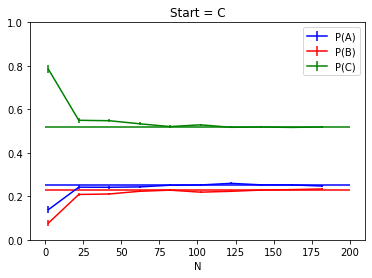

In [6]:
for start in ["A","B","C"]:
    Ns = list(range(2,200,20))
    Ds = [distribution(N, start=start) for N in Ns]
    
    fig, ax = plt.subplots()

    ax.errorbar(Ns, [d[0][0] for d in Ds], [d[1][0] for d in Ds], c='blue', label="P(A)")
    ax.errorbar(Ns, [d[0][1] for d in Ds], [d[1][1] for d in Ds], c='red', label="P(B)")
    ax.errorbar(Ns, [d[0][2] for d in Ds], [d[1][2] for d in Ds], c='green', label="P(C)")
    ax.hlines([unit_evec[0,0].real],0,200,color='blue')
    ax.hlines([unit_evec[1,0].real],0,200,color='red')
    ax.hlines([unit_evec[2,0].real],0,200,color='green')
    ax.legend()
    plt.ylim(0,1)
    plt.title(f"Start = {start}")
    plt.xlabel("N")
    plt.show()

So it seems like these Markov chains tend to **forget about their starting conditions** and settle on a **stationary probability distribution**.  Let us next explore the precise conditions that need to be satisfied for this to happen.

If there is a finite sequence from state $i$ to state $j$ through intermediate states
$l_0=i,l_1,\ldots,l_{m-1},l_m=j$ such that
$$
\begin{align}
 T_{l_s,l_{s+1}} > 0 \,,
\end{align}
$$
we say $i$ communicates with $j$ and write $i \leftrightarrow j$.  This property is transitive
and allows for the definition of equivalence classes.  If a Markov chain just has a single
equivalence class (here called communication class), we say the chain is **irreducible**.

We call $\pi$ a **stationary distribution** of a Markov chain if
\begin{align}
  \pi^T = \pi^T T \,.
\end{align}
If $T$ is irreducible, one can show that $\pi$ exists, is unique, and $\pi_i > 0$ for all $i$.

We define the set of return times for state $i$ as
$$
\begin{align}
  {\cal T}(i) \equiv \{ k \geq 1 \vert (T^k)_{ii} > 0 \}
\end{align}
$$
and the period
$$
\begin{align}
  {\cal P}(i) \equiv \gcd {\cal T}(i) \,.
\end{align}
$$
If ${\cal P}(i) > 1$, we call the state **periodic** else **aperiodic**.
One can show that if $T$ is irreducible, all periods are identical ${\cal P}(i) = {\cal P}$
and we call the entire chain periodic or aperiodic.

In practice we typically will have irreducible chains with at least one state $i$ for which $T_{ii}>0$
so that the typical case is irredicuble aperiodic chains.

In this lecture we discuss only **irreducible aperiodic** chains for which
the **Perron-Frobenius theorem** states that
$T$ has a non-degenerate largest eigenvalue $\lambda_1=1$ with strictly positive left and right
eigenvectors as well as that all other eigenvalues have $\vert\lambda_i\vert<1$.  Such Markov chains forget about their initial conditions and settle on a stationary distribution $\pi$.

**Homework**: find a transition matrix that is not irreducible and aperiodic and repeat the numerical exercises.


## Reversible and ergodic Markov chains

We call a Markov chain **reversible** with respect to $p_{m-1}=\pi$ if
$$
\begin{align}
  P(x_{m} = j \cap x_{m-1} = i) = P(x_{m} = i \cap x_{m-1} = j)
\end{align}
$$
or equivalently
$$
\begin{align}\label{eqn:deba}
  \pi_i T_{ij} = \pi_j T_{ji}
\end{align}
$$
for each $i,j$ (no summation convention here!).  This is also called
the **detailed balance** condition and can be written in matrix form as
$$
\begin{align}
  \Pi T = (\Pi T)^T = T^T \Pi
\end{align}
$$
with $(\Pi)_{ij} = \delta_{ij}\pi_i$.

If we implement a transition probability that satisfies the detailed balance condition
it has a stationary distribution $\pi$.  This is straightforward to see by summing Eq. \eqref{eqn:deba} over $j$.  If it is also irreducible, then the stationary distribution
is unique.  If it is also aperiodic, then it is **ergodic** (can reach all possible states).

Note that a Markov chain does not neet to be reversible for it to be irreducible and aperiodic, as in our three-state example:

In [7]:
# check detailed balance
P = [unit_evec[i,0].real for i in range(3)]

print(P)
print(P[0] * T["A"]["B"], "!=", P[1] * T["B"]["A"])


[0.25287356321839094, 0.22988505747126417, 0.5172413793103449]
0.06321839080459773 != 0.02298850574712642


## Metropolis algorithm

A simple way to generate a Markov chain with a desired stationary distribution is to
propose a new state $j$ given state $i$ with probability $P_{ij}$ and
to accept the proposal with probability $A_{ij}$.
This transition probability for $i \neq j$ is then given by
$$
\begin{align}
  T_{ij} = A_{ij} P_{ij} \,.
\end{align}
$$
If we use
$$
\begin{align}
  A_{ij} = \text{min} \left(1, \frac{\pi_j P_{ji}}{\pi_i P_{ij}} \right)
\end{align}
$$
we can show the detailed balance equation.  Consider without
loss of generality that $\pi_j P_{ji} > \pi_i P_{ij}$, then
$$
\begin{align}
  \pi_i T_{ij} = \pi_i P_{ij} = A_{ji} \pi_j P_{ji} = \pi_j T_{ji} \,.
\end{align}
$$

This choice of transition probability is called the **Metropolis** algorithm.

For $i=j$ the the detailed balance condition always holds.  The transition probability in this case
is
$$
\begin{align}
  T_{ii} = A_{ii} P_{ii} + \sum_{j \neq i} P_{ij} (1-A_{ij}) = P_{ii} + \sum_{j \neq i} P_{ij}(1-A_{ij})  \,.
\end{align}
$$
Therefore also
$$
\begin{align}
  \sum_j T_{ij} &= 
  T_{ii} + \sum_{j\neq i} P_{ij} A_{ij}\,, \\
  &=P_{ii} + \sum_{j\neq i}\left( P_{ij} A_{ij} + P_{ij}(1-A_{ij})\right)\,, \\
  &=P_{ii} + \sum_{j\neq i}P_{ij}\,, \\
  &=\sum_{j}P_{ij} = 1\,.
\end{align}
$$

**Homework**: compute
$$
\frac{\int dx x^2 e^{-x^2/2}}{\int dx e^{-x^2/2}}
$$
by creating your own Markov chain with the desired distribution using Metropolis and computing the statistical mean of $x^2$ in this distribution.

## Example: Harmonic oscillator

We now use the Metropolis algorithm to generate a Markov chain of positions $(x_1,\ldots,x_N)$ distributed according to $p(x_1,\ldots,x_N)$ of the beginning of this chapter.  Note that each possible tuple of positions $(x_1,\ldots,x_N)$ corresponds to one state in the system.  This system has uncountably infinitely many states, however, previous discussion also applies to this case.  If we generate the Markov chain using a computer which has a finite-bit representation of floating point numbers (say 64 bit double precision), the state space is finite in any case.

In [8]:
# define Euclidean action for mass m=1 and V(x)=x^2/2
def S(x, beta):
    N = len(x) - 1
    a = beta / N
    return sum([1/2*(x[j+1]-x[j])**2/a + 1/4*(x[j+1]**2+x[j]**2)*a for j in range(N)])

# contribution from x[j]
def Sj(x, j, beta):
    N = len(x) - 1
    a = beta / N
    jp = (j+1) % N
    jm = (j+N-1) % N
    return x[j]*(x[j] - (x[jp]+x[jm]))/a + 1/2*x[j]**2*a

In [9]:
print(S([0.1,0.33,0.52,0.1], 10)-S([0.2,0.33,0.52,0.2], 10))
print(Sj([0.1,0.33,0.52,0.1],0, 10)-Sj([0.2,0.33,0.52,0.2],0, 10))

print(S([0.1,0.33,0.52,0.1], 10)-S([0.1,0.33*2,0.52,0.1], 10))
print(Sj([0.1,0.33,0.52,0.1],1, 10)-Sj([0.1,0.33*2,0.52,0.1],1, 10))

print(S([0.1,0.33,0.52,0.1], 10)-S([0.1,0.33,0.52*2,0.1], 10))
print(Sj([0.1,0.33,0.52,0.1],2, 10)-Sj([0.1,0.33,0.52*2,0.1],2, 10))

-0.03349999999999986
-0.0335
-0.5811300000000001
-0.5811300000000001
-1.5282800000000003
-1.52828


In [10]:
# since only ratios of probabilities appear, can ignore overall constant factor
def P(x, j, beta):
    # make periodic
    return np.exp(-Sj(x+[x[0]],j,beta))

def sample(N, beta, n_updates, epsilon):
    result = []
    accepted = 0
    rejected = 0
    x = [0.0 for i in range(N)]
    for i in range(n_updates):
        for j in range(N):
            x1 = [x[l] if l != j else x[l] + random.uniform(-epsilon,epsilon) for l in range(N)]
            r = P(x1,j, beta) / P(x,j, beta)
            l = random.uniform(0.0,1.0)
            if l < r:
                # accept
                accepted += 1
                x = x1
            else:
                rejected += 1
        result.append(x)
    print("acceptance rate",accepted / (accepted+rejected))
    return result
        
random.seed(13)
X = [sample(20, 10, 10000, 1.4)[400:] for i in range(20)]

acceptance rate 0.496915
acceptance rate 0.498035
acceptance rate 0.498465
acceptance rate 0.49787
acceptance rate 0.49846
acceptance rate 0.497795
acceptance rate 0.494775
acceptance rate 0.497665
acceptance rate 0.496965
acceptance rate 0.49543
acceptance rate 0.49469
acceptance rate 0.49657
acceptance rate 0.49571
acceptance rate 0.49553
acceptance rate 0.49579
acceptance rate 0.4962
acceptance rate 0.496715
acceptance rate 0.497305
acceptance rate 0.49608
acceptance rate 0.49575


Next we compute
$$
\begin{align}
\langle x_f x_i \rangle 
&=\frac1Z \sum_{n,m} \langle n \vert x \vert m \rangle \langle m \vert x \vert n \rangle  e^{-E_m(\tau_f-\tau_i)}  e^{-E_n (\beta-\tau_f+\tau_i)} \,.
\end{align}
$$

Note that $\hat{x} \propto \hat{a} + \hat{a}^\dagger$, such that the only non-vanishing matrix
elements are between neighboring states.  We have for the first two states
$$
\begin{align}
  \langle 0 \vert x \vert 1 \rangle &= \frac1{\sqrt{2}} \,, \\
  \langle 1 \vert x \vert 0 \rangle &= \frac1{\sqrt{2}} \,, \\
  \langle 1 \vert x \vert 2 \rangle &= 1 \,.
\end{align}
$$

This is straightforward to compute from the wavefunctions
$$
\psi_n(x) = H_n(x) e^{-x^2/2} \frac{\pi^{-1/4}}{\sqrt{2^n n!}} \,.
$$

For sufficiently large $\beta$ and small $\tau_f-\tau_i$ we only have $n=0$ contribute and because
of the matrix elements
$$
\begin{align}
\langle x_f x_i \rangle 
&\approx\frac1Z \vert \langle 1 \vert x \vert 0 \rangle \vert^2  e^{-E_1(\tau_f-\tau_i)}  e^{-E_0 (\beta-\tau_f+\tau_i)} \\
&\approx\vert \langle 1 \vert x \vert 0 \rangle \vert^2  e^{-(E_1 - E_0)(\tau_f-\tau_i)}\,.
\end{align}
$$

Next, we check numerically the matrix elements by integrating the wavefunction:

In [11]:
from scipy import special, integrate
H = [special.hermite(n) for n in range(5)] # get first 5 Hermite polynomials
def psi(x, n):
    return H[n](x)*np.exp(-x**2/2)/np.pi**(1/4)/np.sqrt(2**n * np.math.factorial(n))

# test norms
for n in range(5):
    print(f"|psi({n})|^2=",integrate.quad(lambda x: psi(x,n)**2, -np.inf, np.inf))
    
# compute matrix elements of x operator
for n in range(5):
    print(f"<0|x|{n}>=",integrate.quad(lambda x: psi(x,0)*x*psi(x,n), -np.inf, np.inf))
    
# compute matrix elements of x operator
for n in range(5):
    print(f"<1|x|{n}>=",integrate.quad(lambda x: psi(x,1)*x*psi(x,n), -np.inf, np.inf))
    

|psi(0)|^2= (1.0, 8.012979811542269e-09)
|psi(1)|^2= (1.000000000000002, 3.931389091993226e-09)
|psi(2)|^2= (0.9999999999999994, 9.015428609661171e-09)
|psi(3)|^2= (1.0000000000000007, 3.897728507258696e-09)
|psi(4)|^2= (1.0000000000000007, 1.1156813993696975e-09)
<0|x|0>= (0.0, 0.0)
<0|x|1>= (0.7071067811865492, 1.2850956593672991e-08)
<0|x|2>= (0.0, 0.0)
<0|x|3>= (-3.400058012914542e-16, 2.9488804553452953e-09)
<0|x|4>= (0.0, 0.0)
<1|x|0>= (0.7071067811865492, 1.2850956585037702e-08)
<1|x|1>= (0.0, 0.0)
<1|x|2>= (0.9999999999999999, 1.3187266250307033e-08)
<1|x|3>= (0.0, 0.0)
<1|x|4>= (2.1163626406917047e-16, 3.3229850548566938e-09)


Now we perform a statistical average using the Markov chain data to extract the energies and matrix elements.

In [12]:
print(len(X))

def correlator(X):
    T = 20
    return [ sum([ x[s]*x[(s+t)%T] for s in range(T) for x in X ]) / len(X) / T for t in range(T) ]

correlator_average = [correlator(x) for x in X]

20


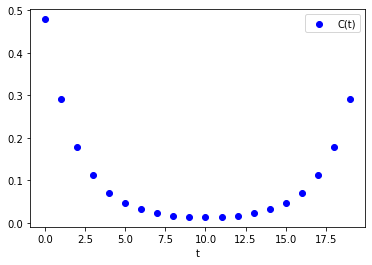

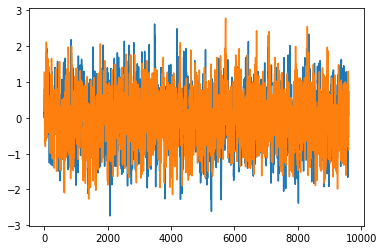

In [13]:
fig, ax = plt.subplots()

ts = list(range(20))
ax.scatter(ts, correlator_average[0], c='blue', label="C(t)")

ax.legend()

plt.xlabel("t")
plt.show()

fig, ax = plt.subplots()

ax.plot([x[0] for x in X[0]])
ax.plot([x[0] for x in X[1]])

plt.show()

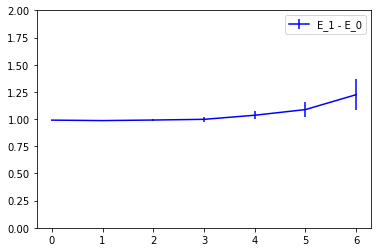

In [14]:
ts = list(range(7))

def effective_mass(C):
    a = 0.5
    return[np.log(C[i]/C[i+1])/a for i in range(7)]

emp = np.array([effective_mass(C) for C in correlator_average])
emp_mean = np.mean(emp, axis=0)
emp_error = np.std(emp, axis=0) / np.sqrt(len(X))

fig, ax = plt.subplots()

plt.ylim([0,2])
ax.errorbar(ts, emp_mean, emp_error, c='blue', label="E_1 - E_0")

ax.legend()
plt.show()

The plateau correspond to $E_1-E_0=1$ of the Harmonic oscillator with $m=1$.

In [15]:
aDeltaE=0.5
opmatel=np.array([[C[t] / (np.exp(-aDeltaE*t) + np.exp(-aDeltaE*(20-t))) for t in range(7)] for C in correlator_average])

opmatel_mean = np.mean(opmatel, axis=0)
opmatel_error = np.std(opmatel, axis=0) / np.sqrt(len(X))

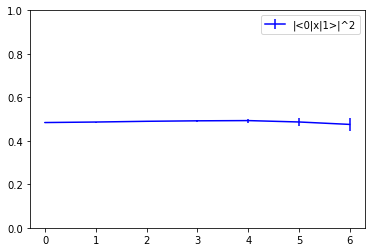

In [16]:
fig, ax = plt.subplots()

plt.ylim([0,1])
ax.errorbar(ts, opmatel_mean, opmatel_error, c='blue', label="|<0|x|1>|^2")

ax.legend()
plt.show()

This needs to be compared with the known $\vert <1|x|0> \vert^2 = \frac12$.

**Homework**: Study the discretization errors ($N$ dependence) in the Harmonic oscillator example.  Then also try the operators $x^3$ instead of $x$.  How do the above plots change.  Explain why!

In the next chapter we study more advanced statistical methods to reduce the cost of the current analysis significantly.  Before venturing on, however, we complete our analytic study of Markov chains by looking at the correlation of variables between two different steps in the Markov chain.

## Convergence and autocorrelation in reversible Markov chains

In this section we discuss only **irreducible aperiodic** chains for which
the **Perron-Frobenius theorem** states that
$T$ has a non-degenerate largest eigenvalue $\lambda_1=1$ with strictly positive left and right
eigenvectors as well as that all other eigenvalues have $\vert\lambda_i\vert<1$.

We first define the matrix
$$
\begin{align}
  S \equiv \Pi^{1/2} T \Pi^{-1/2}
\end{align}
$$
which for **reversible** chains is symmetric since
$$
\begin{align}
  S = \Pi^{1/2} T \Pi^{-1/2} = \Pi^{-1/2} \Pi T \Pi^{-1/2}
  =\Pi^{-1/2} T^T \Pi \Pi^{-1/2}  =\Pi^{-1/2} T^T \Pi^{1/2}
  =(\Pi^{1/2} T \Pi^{-1/2})^T = S^T \,.
\end{align}
$$
From eigenvectors $v_n$ of $S$ with eigenvalues $\tilde{\lambda}_n$
we can then construct right-eigenvectors
$$
\begin{align}
  r_n = \Pi^{-1/2} v_n
\end{align}
$$
of $T$ since
$$
\begin{align}
  T r_n = \Pi^{-1/2} \Pi^{1/2}T \Pi^{-1/2} v_n = \Pi^{-1/2} S v_n = \tilde{\lambda}_n \Pi^{-1/2} v_n
  = \tilde{\lambda}_n r_n \,.
\end{align}
$$
We already know the eigenvalues of $T$ such that $\tilde{\lambda}_n=\lambda_n$.
We also know that
$$
\begin{align}
  l_n = \Pi r_n = \Pi^{1/2} v_n
\end{align}
$$
must be left-eigenvectors of $T$ with same eigenvalues since
$$
\begin{align}
  l_n^T T = v_n^T \Pi^{1/2}T \Pi^{-1/2}\Pi^{1/2}
  = v_n^T S\Pi^{1/2}
  = v_n^T \Pi^{1/2} \lambda_n = \lambda_n l_n^T \,.
\end{align}
$$

We can therefore diagonalize $S$ by
$$
\begin{align}
  S = \sum_n \lambda_n v_n v_n^T
\end{align}
$$
or
$$
\begin{align}
  T = \Pi^{-1/2} S \Pi^{1/2} = \sum_n \lambda_n \Pi^{-1/2} v_n v_n^T \Pi^{1/2}
  =\sum_n \lambda_n r_n l_n^T \,.
\end{align}
$$
We furthermore have
$$
\begin{align}
  \delta_{nm} = v_n^T v_m = l_n^T r_m
\end{align}
$$
such that
$$
\begin{align}
  T^k =\sum_n \lambda^k_n r_n l_n^T \,.
\end{align}
$$
It therefore follows that
$$
\begin{align}
  p_k^T = \sum_n \lambda^k_n p_{0}^T r_n l_n^T \,.
\end{align}
$$

Since $\pi$ is the stationary state, we know that
$\pi=l_1$ and therefore $(r_1)_i=1$, $p_0^T r_1 = \sum_i (p_0)_i=1$, and
$$
\begin{align}
  \lim_{k \to \infty} p_k^T = p_{0}^T r_1 l_1^T
  = \pi^T \,.
\end{align}
$$

So for sufficiently large $k$ we may approximate $p_k = \pi$.  We call
such values of $k$ **thermalized** and compute the autocovariance
$$
\begin{align}
 \textrm{Cov}(t) &= \langle f(x_{k+t}) f(x_k) \rangle-\langle f(x_{k+t}) \rangle \langle f(x_k) \rangle
\end{align}
$$
by
$$
\begin{align}
  \textrm{Cov}(t) + \langle f(x_{k+t}) \rangle \langle f(x_k) \rangle &= \langle f(x_{k+t}) f(x_k) \rangle =
  \sum_{x_{k+t},x_k} f(x_{k+t}) f(x_k) P(x_{k+t} \cap x_k) \\
  &=
  \sum_{x_{k+t},x_k} f(x_{k+t}) f(x_k) P(x_k) (T^t)_{x_k,x_{k+t}}
  =  \sum_{j,i} F_j F_i \pi_i (T^t)_{ij}
  = F^T \Pi T^t F \\
  &= \sum_n \lambda^t_n F^T \Pi r_n l_n^T F
 = \sum_n \lambda^t_n F^T l_n l_n^T F
  = \sum_n \lambda^t_n c_n^2
\end{align}
$$
with $F_i=f(i)$ and $c_n= F^T l_n$.  Finally, using $\langle f(x_{k+t}) \rangle=F^T\pi = c_1$,
we find
$$
\begin{align}
  \textrm{Cov}(t) = \sum_{n \geq 2} \lambda^t_n c_n^2
\end{align}
$$
and we define the autocorrelator
$$
\begin{align}
  C(t) \equiv \frac{\textrm{Cov}(t)}{\textrm{Cov}(0)}
  = \sum_{n \geq 2} \textrm{Sign}(\lambda_n)^t e^{-t / \tau_n} \tilde{c}_n^2
\end{align}
$$
with
$$
\begin{align}
  \tilde{c}_n^2 &\equiv \frac{c_n^2}{\sum_{m \geq 2} c_m^2} \,, &
  \tau_n &= -\frac{1}{\log(\vert\lambda_n \vert)} \,.
\end{align}
$$

The autocovariance therefore falls off exponentially.  The function $f$ determines how large the contribution of the various exponentials is.  If there was a single dominant mode $\tau_2$ with $\lambda_2>0$ and $\tilde{c}_2 \gg \tilde{c}_{3,4,\ldots}$, we would therefore have
$$
C(t) = e^{-t / \tau_2} \,.
$$


### Calculate autocorrelation numerically:

In [17]:
def autocovariance(Y, max_dt):
    mean = sum(Y)/len(Y)
    return [sum([ Y[t]*Y[t+dt] for t in range(len(Y) - dt) ])/(len(Y) - dt) - mean**2. for dt in range(max_dt) ]

def autocorrelator(Y, max_dt):
    Cov = autocovariance(Y, max_dt)
    return [ Cov[t] / Cov[0] for t in range(len(Cov))]

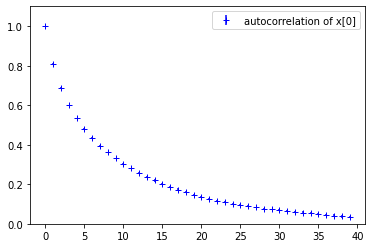

In [18]:
C = np.array([autocorrelator([ Xj[i][0] for i in range(len(Xj)) ], 40) for Xj in X])
C_mean = np.mean(C, axis=0)
C_error = np.std(C, axis=0) / np.sqrt(len(X))

fig, ax = plt.subplots()

plt.ylim([0,1.1])
ax.errorbar(range(len(C_mean)), C_mean, C_error, marker='+', ls='', c='blue', label="autocorrelation of x[0]")

ax.legend()
plt.show()

In the next chapter, we will see how the autocorrelation in a Markov chain relates to the statistical precision of our measurements.